# Applying Inferential Statistics 

### First I'll load my cleaned data sets, create some heatmaps of correlations between the data at the census tract level. 

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.9f' % x)

## Data Joins and Data Frame builds
## Goal is to separate health outcomes from unhealthy behaviors and preventative measures

In [2]:
data = pd.read_csv('../data/cleansed/data.csv')
dataDef = pd.read_csv('../data/cleansed/data_def.csv')
locations = pd.read_csv('../data/cleansed/locations.csv')

In [15]:
data2 = data.set_index('uniqueid').join(locations.set_index('uniqueid')[['geographiclevel','stateabbr','cityname']]).copy()
data2 = data2[data2['geographiclevel'] == 'Census Tract']
data2 = data2.drop(['Unnamed: 0','datavaluetypeid','geographiclevel'],axis=1).reset_index()

In [23]:
dataMelt = data2.melt(id_vars=['uniqueid','stateabbr','cityname','populationcount'],var_name='measureid')
dataMelt.head()

,uniqueid,stateabbr,cityname,populationcount,measureid,value
0,0107000-01073000100,AL,Birmingham,3042.000000000,ACCESS2,0.239000000
1,0107000-01073000300,AL,Birmingham,2735.000000000,ACCESS2,0.288000000
2,0107000-01073000400,AL,Birmingham,3338.000000000,ACCESS2,0.261000000
3,0107000-01073000500,AL,Birmingham,2864.000000000,ACCESS2,0.281000000
4,0107000-01073000700,AL,Birmingham,2577.000000000,ACCESS2,0.318000000


In [152]:
filt1 = dataMelt['measureid']=='SLEEP'
filt2 = dataMelt['measureid']=='LPA'
filt3 = dataMelt['measureid']=='OBESITY'
filt4 = dataMelt['measureid']=='CHD'
filtered = dataMelt[(filt1)|(filt2)|(filt3)|(filt4)]
filtered.head()

,uniqueid,stateabbr,cityname,populationcount,measureid,value
190386,0107000-01073000100,AL,Birmingham,3042.000000000,CHD,0.080000000
190387,0107000-01073000300,AL,Birmingham,2735.000000000,CHD,0.082000000
190388,0107000-01073000400,AL,Birmingham,3338.000000000,CHD,0.088000000
190389,0107000-01073000500,AL,Birmingham,2864.000000000,CHD,0.108000000
190390,0107000-01073000700,AL,Birmingham,2577.000000000,CHD,0.119000000


In [153]:
pivoted = filtered.reset_index().pivot_table('value',['uniqueid','populationcount','stateabbr','cityname'],'measureid')

In [154]:
## Can there be a difference in geography/State?
idx = pd.IndexSlice
newYork = pivoted.loc[idx[:,:,'NY'],:]
texas = pivoted.loc[idx[:,:,'TX'],:]
california = pivoted.loc[idx[:,:,'CA'],:]
connecticut = pivoted.loc[idx[:,:,'CT'],:]

nyObesity = newYork.OBESITY.values
txObesity = texas.OBESITY.values
caObesity = california.OBESITY.values
ctObesity = connecticut.OBESITY.values

In [155]:
## Hypothesis: NY and TX Obesity Rates Are the Same
# Shift means to be the same mean, take 10000 random samples, and subtract TX from NY
def stateMeans(a,b,size=10000):
    comb = np.concatenate([a,b])
    shiftedA = a - a.mean() + comb.mean()
    shiftedB = b - b.mean() + comb.mean()

    replicateCount = size
    replicateDiffs = np.empty(replicateCount)

    for i in range(replicateCount):
        tmpA = np.random.choice(shiftedA,size=len(shiftedA))
        tmpB = np.random.choice(shiftedB,size=len(shiftedB))
        replicateDiffs[i]= tmpA.mean() - tmpB.mean()
        
    return replicateDiffs

<b>Null Hypothesis:</b> There is no difference between the obesity rate of censuses in Texas and New York <BR>
<b>Test Statistic:</b> Difference of Means Betwee NY & TX

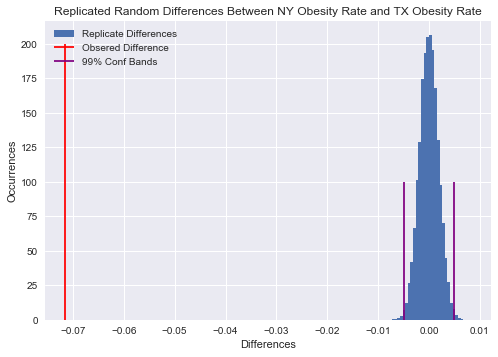

Observed Difference: -0.071
99% Conf Intervals: (-0.005, 0.005)
P Value: 0.000
We can reject the null hypothesis that there is no differnece between obesity rates in NY & TX


In [156]:
## Plt differences of random samples, observed diff, 
obsDiff = nyObesitySimpleMean-txObesitySimpleMean
replicateDiffs =stateMeans(nyObesity,txObesity,25000)
plt.hist(replicateDiffs,bins=30,normed=True,label='Replicate Differences')
plt.vlines(obsDiff,0,200,color='red',label='Obsered Difference')

## Generate Confidence Intervals

low,high = np.percentile(replicateDiffs,[.5,99.5])
plt.vlines(low,0,100,color='purple',label='99% Conf Bands')
plt.vlines(high,0,100,color='purple')
plt.title('Replicated Random Differences Between NY Obesity Rate and TX Obesity Rate')
plt.ylabel('Occurrences')
plt.xlabel('Differences')
plt.legend()
plt.savefig('img/nyVstxObesity.png')
plt.show()

pval = np.sum(replicateDiffs<obsDiff)/len(replicateDiffs)

print('Observed Difference: {0:0.3f}'.format(obsDiff))
print('99% Conf Intervals: ({0:0.3f}, {1:0.3f})'.format(low,high))
print('P Value: {0:0.3f}'.format(pval))
print('We can reject the null hypothesis that there is no differnece between obesity rates in NY & TX')

In [157]:
tstat = ((nyObesity.mean() - txObesity.mean())-0)/np.sqrt((nyObesity.std()**2/len(nyObesity))+(txObesity.std()**2/len(txObesity)))
print('Calc t stat p value: {0:0.5f}'.format(stats.norm.pdf(tstat)*2))
print('Scipy Stats T stat p value: {0:0.5f}'.format(stats.ttest_ind(nyObesity,txObesity,)[1]))
print('Again, we can reject the null hypothesis that there is no difference between obesity rates in NY & TX')

Calc t stat p value: 0.00000
Scipy Stats T stat p value: 0.00000
Again, we can reject the null hypothesis that there is no difference between obesity rates in NY & TX


<b>Null Hypothesis:</b> There is no difference between the obesity rate of censuses in California and New York <BR>
<b>Test Statistic:</b> Difference of Means Betwee NY & CA

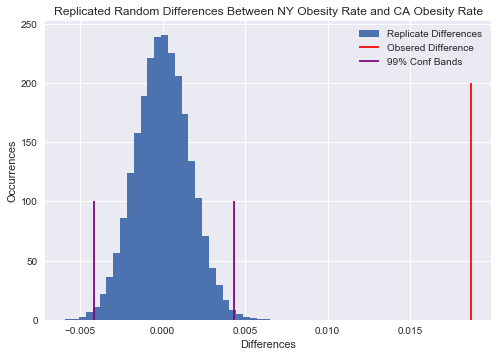

Observed Difference: 0.019
99% Conf Intervals: (-0.004, 0.004)
P Value: 0.000
We can reject the null hypothesis that there is no differnece between obesity rates in NY & CA


In [158]:
## Plt differences of random samples, observed diff, 
obsDiff = nyObesity.mean()-caObesity.mean()
replicateDiffs =stateMeans(nyObesity,caObesity,25000)
plt.hist(replicateDiffs,bins=30,normed=True,label='Replicate Differences')
plt.vlines(obsDiff,0,200,color='red',label='Obsered Difference')

## Generate Confidence Intervals

low,high = np.percentile(replicateDiffs,[.5,99.5])
plt.vlines(low,0,100,color='purple',label='99% Conf Bands')
plt.vlines(high,0,100,color='purple')
plt.title('Replicated Random Differences Between NY Obesity Rate and CA Obesity Rate')
plt.ylabel('Occurrences')
plt.xlabel('Differences')
plt.legend()
plt.savefig('img/nyVscaObesity.png')
plt.show()

pval = np.sum(replicateDiffs>obsDiff)/len(replicateDiffs)

print('Observed Difference: {0:0.3f}'.format(obsDiff))
print('99% Conf Intervals: ({0:0.3f}, {1:0.3f})'.format(low,high))
print('P Value: {0:0.3f}'.format(pval))
print('We can reject the null hypothesis that there is no differnece between obesity rates in NY & CA')

In [159]:
tstat = ((nyObesity.mean() - caObesity.mean())-0)
tstat /= np.sqrt((nyObesity.std()**2/len(nyObesity))+(caObesity.std()**2/len(caObesity)))
print('Calc t stat p value: {0:0.5f}'.format(stats.norm.pdf(tstat)*2))
print('Scipy Stats T stat p value: {0:0.5f}'.format(stats.ttest_ind(nyObesity,caObesity,)[1]))
print('Again, we can reject the null hypothesis that there is no differnece between obesity rates in NY & CA')

Calc t stat p value: 0.00000
Scipy Stats T stat p value: 0.00000
Again, we can reject the null hypothesis that there is no differnece between obesity rates in NY & CA


<b>Null Hypothesis:</b> There is no difference between the obesity rate of censuses in Connecticut and New York <BR>
<b>Test Statistic:</b> Difference of Means Betwee NY & CT

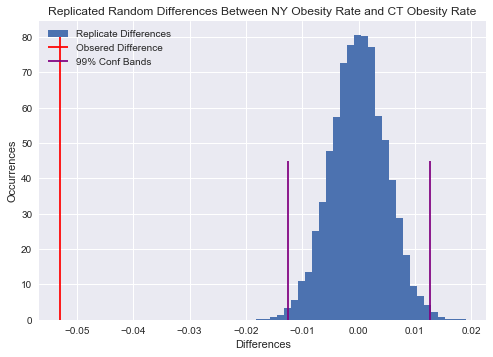

Observed Difference: -0.053
99% Conf Intervals: (-0.012, 0.013)
P Value: 0.000
We can reject the null hypothesis that there is no differnece between obesity rates in NY & CT


In [160]:
## Plt differences of random samples, observed diff, 
obsDiff = nyObesity.mean()-ctObesity.mean()
replicateDiffs =stateMeans(nyObesity,ctObesity,10000)
plt.hist(replicateDiffs,bins=30,normed=True,label='Replicate Differences')
plt.vlines(obsDiff,0,80,color='red',label='Obsered Difference')

## Generate Confidence Intervals

low,high = np.percentile(replicateDiffs,[.5,99.5])
plt.vlines(low,0,45,color='purple',label='99% Conf Bands')
plt.vlines(high,0,45,color='purple')
plt.title('Replicated Random Differences Between NY Obesity Rate and CT Obesity Rate')
plt.ylabel('Occurrences')
plt.xlabel('Differences')
plt.legend()
plt.savefig('img/nyVsctObesity.png')
plt.show()

pval = np.sum(replicateDiffs<obsDiff)/len(replicateDiffs)

print('Observed Difference: {0:0.3f}'.format(obsDiff))
print('99% Conf Intervals: ({0:0.3f}, {1:0.3f})'.format(low,high))
print('P Value: {0:0.3f}'.format(pval))
print('We can reject the null hypothesis that there is no differnece between obesity rates in NY & CT')

In [161]:
tstat = ((nyObesity.mean() - ctObesity.mean())-0)/np.sqrt((nyObesity.std()**2/len(nyObesity))+(ctObesity.std()**2/len(ctObesity)))
print('Calc t stat p value: {0:0.5f}'.format(stats.norm.pdf(tstat)*2))
print('Scipy Stats T stat p value: {0:0.5f}'.format(stats.ttest_ind(nyObesity,ctObesity,)[1]))
print('Again, we can reject the null hypothesis that there is no differnece between obesity rates in NY & CT')

Calc t stat p value: 0.00000
Scipy Stats T stat p value: 0.00000
Again, we can reject the null hypothesis that there is no differnece between obesity rates in NY & CT


In [162]:
np.sqrt((nyObesity.std()**2/len(nyObesity))-(ctObesity.std()**2/len(ctObesity)))

C:\Users\rich.wolff\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


nan

In [176]:
def regReplicatePlot(x,y,size=100):
    obesity = pivoted['OBESITY']
    lpa = pivoted['LPA']
    slope,intercept = np.polyfit(x,y,1)
    fig,ax = plt.subplots(1,1,figsize=(15,5))
    plt.plot(x,y,marker='.',linestyle='none',alpha=.4)
    xminmax = np.array([x.min(),x.max()])

    for i in range(size):
        #List of temp index
        inds = np.arange(len(x))

        #Random Index Locations
        b_inds = np.random.choice(inds,len(inds))

        #Select x & y lines based on random index
        tx = x[b_inds].values
        ty = y[b_inds].values

        #generate random regression line & plot
        tslope,tint = np.polyfit(tx,ty,1)
        plt.plot(xminmax,xminmax*tslope+tint,color='green',alpha=.2,linewidth=.25)

    #Plot observed regression line
    plt.plot(xminmax,xminmax*slope+intercept,color='red',linewidth=.5)
    return fig

def corr_BS(x,y,size=1):

    reps = np.empty(size)
    inds = np.arange(len(x))
    for i in range(size):

        #Random Index Locations
        tx = np.random.permutation(x)
        reps[i] = stats.pearsonr(tx,y)[0]
        
    return reps

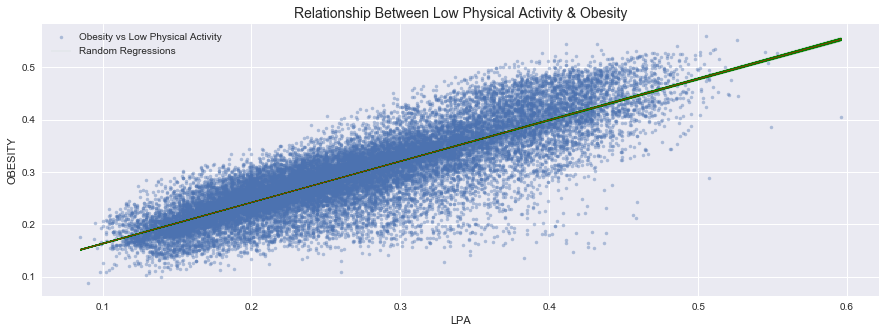

Pearson Correlation: 0.841
P-Value: 0.00000


In [181]:
fig = regReplicatePlot(pivoted['LPA'],pivoted['OBESITY'],1000)

#plot labels & title
plt.title('Relationship Between Low Physical Activity & Obesity',fontsize=14)
plt.xlabel('LPA')
plt.ylabel('OBESITY')

#Save figure and show
plt.savefig('img/lpaObesity1kreg.png')
plt.legend(['Obesity vs Low Physical Activity','Random Regressions'],)
plt.show()

orgCorr, p = stats.pearsonr(pivoted['LPA'],pivoted['OBESITY'])
print('Pearson Correlation: {0:0.3f}'.format(orgCorr))
print('P-Value: {0:0.5f}'.format(p))

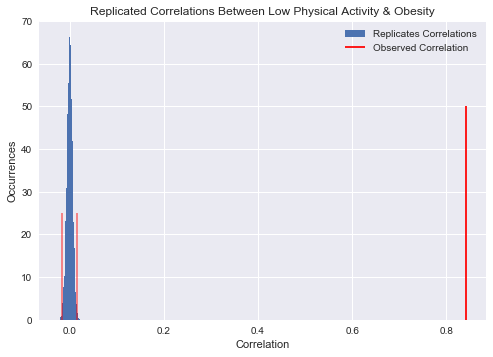

Null Hypothesis: There is no correlation between Low Physical Activity
Confidence Intervals: (-0.0153,0.0156)
Original Observed Correlation: 0.8406
P Value From Replicates: 0.00000
We can reject the null hypothesis that there is no correlation between LPA and Obesity


In [190]:
## Prove out correlation with pvalue = 0.00000 by creating 10,000 replicates and taking p value
reps = corr_BS(pivoted['LPA'],pivoted['OBESITY'],10000)
orgCorr = stats.pearsonr(pivoted['LPA'],pivoted['OBESITY'])[0]

plt.hist(reps,bins=30,normed=True,label='Replicates Correlations')
plt.vlines(orgCorr,0,50,color='red',label='Observed Correlation')
confInt = np.percentile(reps,[.5,99.5])
plt.vlines(confInt[0],0,25,color='red',alpha=.5)
plt.vlines(confInt[1],0,25,color='red',alpha=.5)
plt.title('Replicated Correlations Between Low Physical Activity & Obesity')
plt.xlabel('Correlation')
plt.ylabel('Occurrences')
plt.legend()
plt.show()

pval = np.sum(reps>orgCorr)/len(reps)
print('Null Hypothesis: There is no correlation between Low Physical Activity')
print('Confidence Intervals: ({0:0.4f},{1:0.4f})'.format(confInt[0],confInt[1]))
print('Original Observed Correlation: {0:0.4f}'.format(orgCorr))
print('P Value From Replicates: {0:0.5f}'.format(pval))
print('We can reject the null hypothesis that there is no correlation between LPA and Obesity')

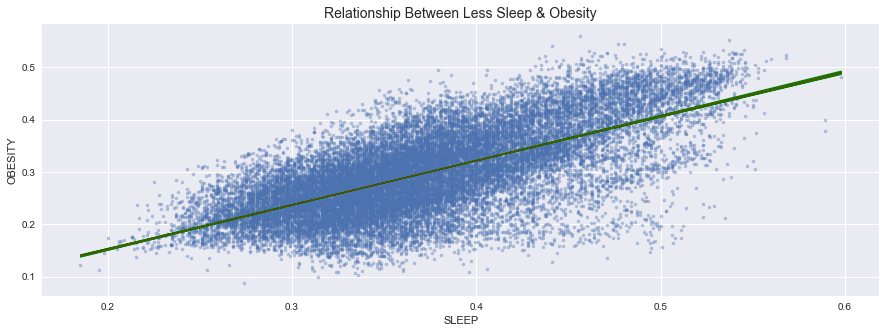

Pearson Correlation: 0.682
P-Value: 0.00000


In [183]:
fig = regReplicatePlot(pivoted['SLEEP'],pivoted['OBESITY'],1000)

#plot labels & title
plt.title('Relationship Between Less Sleep & Obesity',fontsize=14)
plt.xlabel('SLEEP')
plt.ylabel('OBESITY')

#Save figure and show
plt.savefig('img/sleepObesity1kreg.png')
plt.show()

orgCorr, p = stats.pearsonr(pivoted['SLEEP'],pivoted['OBESITY'])
print('Pearson Correlation: {0:0.3f}'.format(orgCorr))
print('P-Value: {0:0.5f}'.format(p))

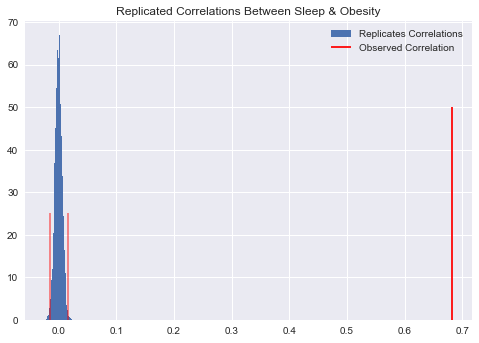

Null Hypothesis: There is no correlation between Low amount of Sleep and Obesity
Confidence Intervals: (-0.0157,0.0157)
Original Observed Correlation: 0.6816
P Value From Replicates: 1.00000
We can reject the null hypothesis that there is no correlation between Low amounts of sleep and Obesity


In [184]:
## Prove out correlation with pvalue = 0.00000 by creating 10,000 replicates and taking p value
reps = corr_BS(pivoted['SLEEP'],pivoted['OBESITY'],10000)
plt.hist(reps,bins=30,normed=True,label='Replicates Correlations')
plt.vlines(orgCorr,0,50,color='red',label='Observed Correlation')
confInt = np.percentile(reps,[.5,99.5])
plt.vlines(confInt[0],0,25,color='red',alpha=.5)
plt.vlines(confInt[1],0,25,color='red',alpha=.5)
plt.title('Replicated Correlations Between Sleep & Obesity')
plt.legend()
plt.show()

pval = np.sum(reps<orgCorr)/len(reps)
print('Null Hypothesis: There is no correlation between Low amount of Sleep and Obesity')
print('Confidence Intervals: ({0:0.4f},{1:0.4f})'.format(confInt[0],confInt[1]))
print('Original Observed Correlation: {0:0.4f}'.format(orgCorr))
print('P Value From Replicates: {0:0.5f}'.format(pval))
print('We can reject the null hypothesis that there is no correlation between Low amounts of sleep and Obesity')

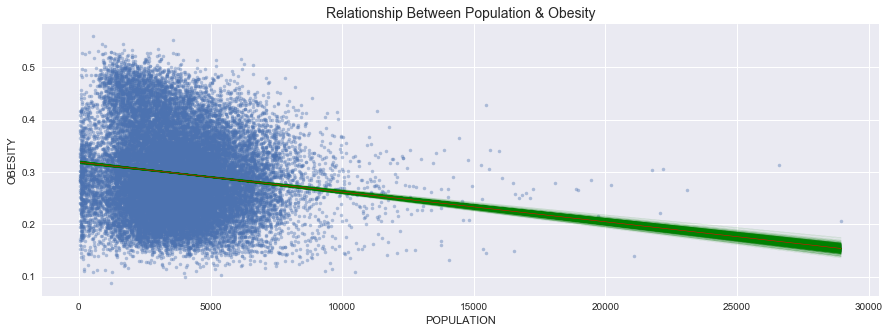

Pearson Correlation: -0.139
P-Value: 0.00000


In [191]:
fig = regReplicatePlot(pivoted.reset_index()['populationcount'],pivoted['OBESITY'],1000)

#plot labels & title
plt.title('Relationship Between Population & Obesity',fontsize=14)
plt.xlabel('POPULATION')
plt.ylabel('OBESITY')

#Save figure and show
plt.savefig('img/sleepObesity1kreg.png')
plt.show()

orgCorr, p = stats.pearsonr(pivoted.reset_index()['populationcount'],pivoted['OBESITY'])
print('Pearson Correlation: {0:0.3f}'.format(orgCorr))
print('P-Value: {0:0.5f}'.format(p))

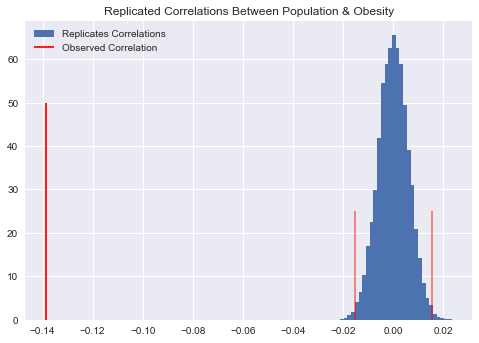

Null Hypothesis: There is no correlation between Population Count and Obesity
Confidence Intervals: (-0.0154,0.0156)
Original Observed Correlation: -0.1387
P Value From Replicates: 0.00000
We can reject the null hypothesis that there is no correlation between Population Count and Obesity


In [171]:
## Prove out correlation with pvalue = 0.00000 by creating 10,000 replicates and taking p value
reps = corr_BS(pivoted.reset_index()['populationcount'],pivoted['OBESITY'],10000)
plt.hist(reps,bins=30,normed=True,label='Replicates Correlations')
plt.vlines(orgCorr,0,50,color='red',label='Observed Correlation')
confInt = np.percentile(reps,[.5,99.5])
plt.vlines(confInt[0],0,25,color='red',alpha=.5)
plt.vlines(confInt[1],0,25,color='red',alpha=.5)
plt.title('Replicated Correlations Between Population & Obesity')
plt.legend()
plt.show()

pval = np.sum(reps<orgCorr)/len(reps)
print('Null Hypothesis: There is no correlation between Population Count and Obesity')
print('Confidence Intervals: ({0:0.4f},{1:0.4f})'.format(confInt[0],confInt[1]))
print('Original Observed Correlation: {0:0.4f}'.format(orgCorr))
print('P Value From Replicates: {0:0.5f}'.format(pval))
print('We can reject the null hypothesis that there is no correlation between Population Count and Obesity')